# CS 3110/5110: Data Privacy
## In-Class Exercise, 10/21/2024

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

In [2]:
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

## Question 1

Calculate the empirical *cumulative distribution function* of ages in the adult dataset. Use the RDP Gaussian mechanism.

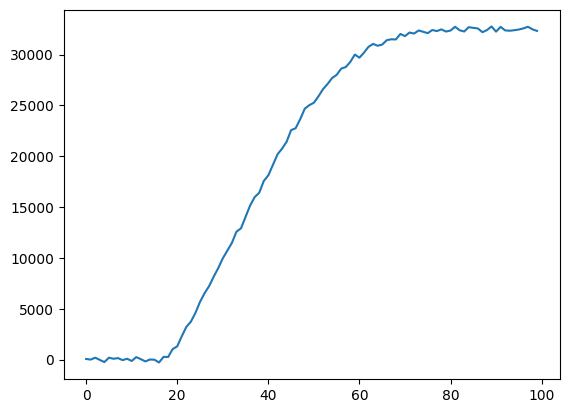

In [3]:
def calculate_cdf():
    alpha = 5 # integer > 1 - bigger alpha => better privacy
    epsilon = 0.0001 # Small real number - smaller epsilon => better privacy.
    # To evaluate if they're good, convert to (epsilon, delta)

    a = adult['Age']
    cdf = [len(a[a < i]) for i in range(100)]

    # Option 1: use the single-value Gaussian mechanism and composition.
    noisy_cdf = [gaussian_mech_RDP(v, sensitivity=1, alpha=alpha, epsilon=epsilon) for v in cdf]

    return noisy_cdf
    
    #Option 2: we use the vector-value Gaussian mechanism and no composition.

cdf_vals = calculate_cdf()
plt.plot(cdf_vals);

## Question 2

What is the *total privacy cost* in RDP of your solution above?

1. Sensitivity: each element of the CDF is a counting query, so it has sensitivity 1.
2. Composition: total cost is ($\alpha$, $100 \epsilon$) -RDP by sequential composition.
3. Post Processing: We return the noisy CDF, which satisfies RDP by post-processing.

## Question 3

What is the *total privacy cost* in $(\epsilon, \delta)$-differential privacy of your solution above, for $\delta = 10^{-5}$?

The total privacy cost in ($\epsilon$, $\delta$)-DP is $\epsilon=2.88$, $\delta=10^{-5}$

## Question 4

Repeat the above, but for zero-concentrated differential privacy.

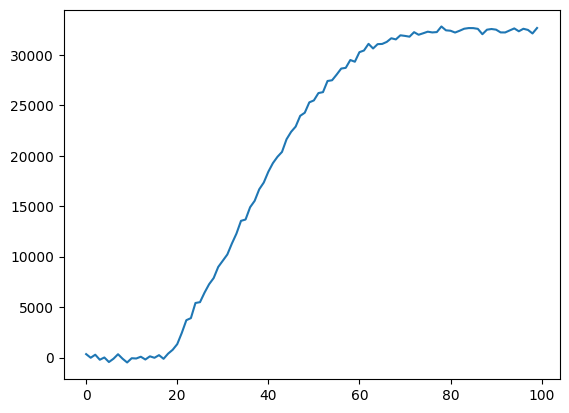

In [4]:
def gaussian_mech_zCDP(val, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2)/(2 * rho))
    return val + np.random.normal(loc=0, scale=sigma)

def calculate_cdf_zcdp():
    rho = 0.00001
    
    a = adult['Age']
    cdf = [len(a[a < i]) for i in range(100)]

    # Option 1: use the single-value Gaussian mechanism and composition.
    noisy_cdf = [gaussian_mech_zCDP(v, sensitivity=1 , rho=rho) for v in cdf]

    return noisy_cdf

cdf_vals = calculate_cdf_zcdp()
plt.plot(cdf_vals);

In [5]:
def zcdp_convert(rho, delta):
    return rho + 2 * np.sqrt(rho * np.log(1/delta))

zcdp_convert(rho=0.001, delta=1e-50)

0.6796140424415112

In [7]:
# What do alpha, epsilon_bar, and rho actually mean?
# What is the actual definition in math of RDP and zCDP?
# How should I decide which one to use (kind of)
# - You shuold use zCDP if you can
# - Always use zcdp or rdp if you're doing a loop with many iterations
#   both are much better than advanced sequential composition in
#   epsilon or (epsilon, delta)-DP

## Question 5

The code below defines a finite set of options for marital status. Define a *scoring function* that returns high scores for common marital statuses, and low scores for uncommon ones (e.g. the score could be the number of people with that status).

In [10]:
options = ['Never-married', 'Married-civ-spouse', 'Divorced',
           'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
           'Widowed']

def score(option):
    # how many people have marital status
    return len(adult[adult['Marital Status'] == option])

score('Never-married')

10683

In [11]:
# TEST CASE
assert score('Never-married') == 10683

In [12]:
# what is the option with the highest score
max([(x, score(x)) for x in options], key=lambda x: x[1])[0]

'Married-civ-spouse'

## Question 6

Implement `report_noisy_max` using the Laplace mechanism. `report_noisy_max` should return the value in a set that approximately maximizes the value of the score function. It should *not* return the score itself.

In [13]:
def report_noisy_max(R, score, sensitivity, epsilon):
    # calculate all the scores
    scores = [score(option) for option in R]

    # add noise to all the scores
    noisy_scores = [laplace_mech(score,
                                 sensitivity=sensitivity,
                                 epsilon=epsilon)
                    for score in scores]
    
    # release the option that has the highest score
    max_idx = np.argmax(noisy_scores)
    return R[max_idx]

report_noisy_max(options, score, 1, 1)

'Married-civ-spouse'

In [14]:
# TEST CASE
assert report_noisy_max(options, score, 1, 1) == 'Married-civ-spouse'

## Question 7

What is the **total privacy cost** of `report_noisy_max` under *sequential composition*?

1. Sensitivity: Assuming the caller specifies the right sensitivity, we call the Laplace mech
with the correct sensitivity for the scoring function
2. Composition: We run the Laplace mechanism k times when there are k option. So the total
privacy cost is $k*\epsilon$ where k is the length of the options list, by sequential
compsition
3. Post-processing: max_idx satisfies DP by post-processing, so `R[max_idx]` does too (note that R is public information)

## Above Threshold

The following code implements Above Threshold:

In [ ]:
# preserves epsilon-differential privacy
def above_threshold(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
    return -1 # the index of the last element

## Question 8

Use `above_threshold` to find the first `age` for which `len(adult[adult['Age'] == age]) >= 800` (the first age for which more than 800 people have that age).

In [ ]:
def make_query(age):
    def q(df):
        return len(df[df['Age'] == age])
    return q

def find_first_age_above_800(epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()
    
find_first_age_above_800(1.0)

In [ ]:
# TEST CASE
assert find_first_age_above_800(1.0) == 22

## Question 9

Use `above_threshold` to implement `pick_b` for the following summation query. `pick_b` should pick a clipping parameter `b`.

In [ ]:
def make_query(b):
    def q(df):
        # YOUR CODE HERE
        raise NotImplementedError()
    return q

def pick_b(epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()
    
pick_b(1.0)

In [ ]:
# TEST CASE
b = pick_b(1.0)
assert b > 80
assert b < 100

## Question 10

Implement `above_threshold_val`, which returns the *value* of the first query result above the threshold. Your solution should have a **total privacy cost** of `epsilon`.

In [ ]:
def make_query(age):
    def q(df):
        return len(df[df['Age'] == age])
    return q

def above_threshold_val(queries, df, T, epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()
    
queries = [make_query(age) for age in range(0,100)]
above_threshold_val(queries, adult, 800, 1.0)

In [ ]:
# TEST CASE
queries = [make_query(age) for age in range(0,100)]

results = [above_threshold_val(queries, adult, 800, 1.0) for _ in range(20)]
assert np.mean(results) > 865
assert np.mean(results) < 890

## Question 11

Argue that your solution in question 10 has a total privacy cost of `epsilon`.

YOUR ANSWER HERE